In [1]:
import galarp as grp
from galarp import InterpolatedWind, InterpolatedDensity

grp.pyplot_style()
cmap = grp.lavender_cmap(step_1=50)

import numpy as np

from astropy import units as u
from astropy.table import Table

from gala.units import galactic
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt

from scipy import stats
from scipy.interpolate import interp1d

from astropy.modeling.models import Gaussian1D, custom_model
from astropy.modeling.fitting import LevMarLSQFitter

In [2]:
orbits = grp.OrbitContainer.load("temp/orbits_JZ_dup.grp")

print(orbits)

In [3]:
times, rstrips = grp.rstrip(orbits)

r_final = grp.final_rstrip(orbits)


In [4]:
grp.rstrip_plot(orbits, title="Stripping Radius", rstrip_frac=0.8, zmax=2 * u.kpc, rmax=20 * u.kpc, 
            outname="figures/stripping_radius_JZ.pdf", close_plot=True)

In [5]:
def evaluate_ellipse_coordinates(t, a, b, phi, theta):
    """
    Evaluate the coordinates of an ellipse at local angles [t], rotated by phi and theta in spherical coordinates.

    Parameters:
    - t (float or array-like): Local angles at which to evaluate the ellipse.
    - a (float): Semi-major axis of the ellipse.
    - b (float): Semi-minor axis of the ellipse.
    - phi (float): Rotation angle around the z-axis.
    - theta (float): Rotation angle around the x-axis.

    Returns:
    - x (float or array-like): x-coordinates of the evaluated points.
    - y (float or array-like): y-coordinates of the evaluated points.
    - z (float or array-like): z-coordinates of the evaluated points.
    """
    x = a * np.cos(t) * np.cos(phi) - b * np.sin(t) * np.sin(phi)
    y = a * np.cos(t) * np.sin(phi) + b * np.sin(t) * np.cos(phi)
    z = a * np.sin(t) * np.sin(theta)
    
    return x, y, z

/Users/hsouchereau/galarp/galarp/postprocessing/plotting/general_plots.py:314: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


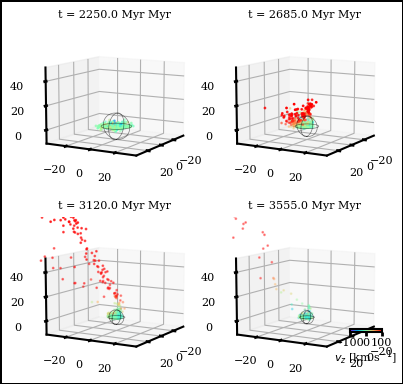

In [12]:
#grp.pyplot_3D_plot(orbits, nrows=5, ncols=4, tmin=450, tmax=800, cmap="rainbow", rmax=35, outname="figures/orbits_3D_JZ.pdf", dpi=50)

grp.pyplot_3D_plot(orbits, nrows=2, ncols=2, tmin=450, tmax=800, cmap="rainbow", rmax=35, outname="figures/example_3D_plot.pdf", dpi=50)